<a href="https://colab.research.google.com/github/bt22dr/deep-learning-papers/blob/master/code/conditional_vae_fashion_mnist_org.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고한 소스
 * https://arxiv.org/pdf/1711.10604.pdf
 * https://danijar.com/building-variational-auto-encoders-in-tensorflow/
 * https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/cvae.ipynb

In [1]:
!pip install imageio

In [2]:
%matplotlib inline

import os
import sys
import glob
import time
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Dense, Concatenate
from tensorflow.keras.utils import to_categorical
tf.enable_eager_execution()

import tensorflow_probability as tfp
tfd = tfp.distributions

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Found GPU at: /device:GPU:0
TensorFlow version: 1.13.0-rc0
Eager execution: True


![큰 그림에서의 각 모듈간의 관계도](https://github.com/bt22dr/deep-learning-papers/blob/master/code/images/vae/modules.png?raw=1)

출처: Variational Inference and Deep Learning: A New Synthesis

In [0]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
(train_X, train_y), (test_X, test_y) = tf.keras.datasets.fashion_mnist.load_data()

train_X = train_X.reshape(train_X.shape[0], -1).astype('float32')
test_X  = test_X.reshape(test_X.shape[0], -1).astype('float32')

train_X = train_X / 255.
test_X  = test_X / 255.

print("x_train shape:", train_X.shape, "y_train shape:", train_y.shape)

x_train shape: (60000, 784) y_train shape: (60000,)


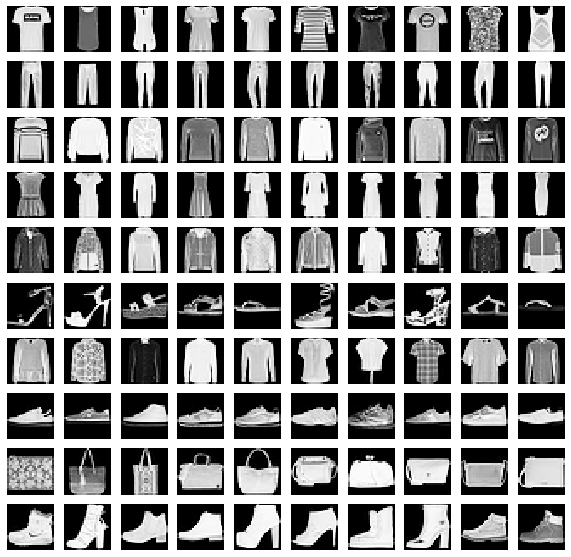

In [5]:
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(10,10), 
                         nrows=rows, ncols=cols, 
                         sharex=True, sharey=True)

for i, ax_row in enumerate(axes):
  imgs = train_X[np.where(train_y == i)[0][:10]]
  for j, ax in enumerate(ax_row):
    _ = ax.imshow(np.reshape(imgs[j], (28,28)), cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, dim_x=784, dim_z=2, dim_h=256, dim_label=10):
    super(CVAE, self).__init__()
    self.dim_x = dim_x
    self.dim_z = dim_z
    self.dim_h = dim_h
    self.dim_label = dim_label
    self.inference_net = tf.keras.Sequential([
      InputLayer(input_shape=(self.dim_x+self.dim_label,)),
      Dense(self.dim_h, activation=tf.nn.leaky_relu),
      Dense(self.dim_h, activation=tf.nn.leaky_relu),
      Dense(self.dim_z*2, activation=None)])
    self.generative_net = tf.keras.Sequential([
      InputLayer(input_shape=(self.dim_z+self.dim_label,)),
      Dense(self.dim_h, activation=tf.nn.leaky_relu),
      Dense(self.dim_h, activation=tf.nn.leaky_relu),
      Dense(self.dim_x, activation=None)])
  
  def sample_z(self, x, condition):
    q_mu, q_sigma = model.encode(x, condition)
    q_z_given_x = tfd.MultivariateNormalDiag(q_mu, q_sigma)
    z_samples = q_z_given_x.sample()
    return z_samples
  
  def sample_x(self, z, condition):
    probs = model.decode(z, condition, apply_sigmoid=True)
    p_x_given_z = tfd.Bernoulli(probs=probs)
    p_x_given_z_mean = tfd.Independent(p_x_given_z).mean()
    p_x_given_z_sample = p_x_given_z.sample()
    return p_x_given_z_mean, p_x_given_z_sample
  
  def encode(self, x, condition):
    xc = tf.concat(axis=1, values=[x, condition])
    q_mu, q_sigma = tf.split(self.inference_net(xc), num_or_size_splits=2, axis=1)  
    q_sigma = tf.nn.softplus(q_sigma)
    return q_mu, q_sigma

  def decode(self, z, condition, apply_sigmoid=False):
    zc = tf.concat(axis=1, values=[z, condition])
    logits = self.generative_net(zc)
    if apply_sigmoid:
      probs = tf.nn.sigmoid(logits)
      return probs
    return logits

![architecture](https://github.com/bt22dr/deep-learning-papers/blob/master/code/images/vae/architecture01.png?raw=1)

![architecture](https://github.com/bt22dr/deep-learning-papers/blob/master/code/images/vae/architecture02.png?raw=1)

In [7]:
dim_z=2
model = CVAE(dim_z=dim_z)

Instructions for updating:
Colocations handled automatically by placer.


![ELBO equation](https://github.com/bt22dr/deep-learning-papers/blob/master/code/images/vae/elbo_equation.png?raw=1)

In [0]:
def compute_loss(model, x, labels):
  # posterior, q(z|x), encoder
  q_mu, q_sigma = model.encode(x, labels)
  q_z_given_x = tfd.MultivariateNormalDiag(q_mu, q_sigma)
  z_samples = q_z_given_x.sample()
  
  # likelihood, p(x|z), decoder
  p_x_given_z_logits = model.decode(z_samples, labels)
  p_x_given_z = tfd.Bernoulli(logits=p_x_given_z_logits)
  
  # prior, p(z), standard normal distribution
  p_z = tfd.MultivariateNormalDiag(np.zeros(z_samples.shape[1], dtype=np.float32))

  divergence = tf.reduce_sum(tfd.kl_divergence(q_z_given_x, p_z))
  likelihood = tf.reduce_sum(p_x_given_z.log_prob(x))
  elbo = tf.reduce_mean(-divergence + likelihood)
  
  return -elbo

def compute_gradients(model, x, labels):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, labels)
  return tape.gradient(loss, model.trainable_variables), loss

optimizer = tf.train.AdamOptimizer(1e-4)
def apply_gradients(optimizer, gradients, variables, global_step=None):
  optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
test_dataset  = tf.data.Dataset.from_tensor_slices((test_X, test_y))

train_dataset = train_dataset.shuffle(60000).batch(100)
iter = test_dataset.batch(10000).make_one_shot_iterator()
test_sample_x, test_sample_label = iter.get_next()
test_sample_z = tf.random_normal(shape=[10, dim_z])

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [0]:
def generate_and_save_images(epoch, itr):
  display.clear_output(wait=False)
  np_z   = model.sample_z(test_sample_x, to_categorical(test_sample_label, num_classes=10))
  np_x,_ = model.sample_x(test_sample_z, to_categorical(range(10)))
  
  fig = plt.figure(figsize=(11,1))
  
  ax1 = plt.subplot(1, 11, 1)
  ax1.scatter(np_z[:,0], np_z[:,1], s=2, c=test_sample_label, alpha=0.1, cmap='tab10')
  ax1.set_aspect('equal')
  ax1.set_xlim(-4, 4)
  ax1.set_ylim(-4, 4)
  ax1.tick_params(axis='both', which='both', left=False, 
                  bottom=False, labelleft=False, labelbottom=False)
  
  for i, sample in enumerate(np.reshape(np_x, (-1,28,28))):
    plt.subplot(1, 11, i+2)
    plt.imshow(sample, cmap='gray')
    plt.axis('off')
    
  plt.savefig('image_at_epoch_{:04d}_{:04d}.png'.format(epoch, itr))
  plt.show()

In [0]:
!rm -rf *.png *.gif

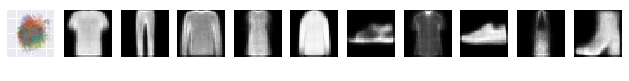

Epoch: 49, Test set ELBO: -25172.126953125, time elapse for current epoch 19.72675132751465


In [12]:
num_epochs = 50

for epoch in range(num_epochs):
  start_time = time.time()
  avg_loss = tf.keras.metrics.Mean()
  for i, (train_x, train_y) in enumerate(train_dataset):
    train_y = to_categorical(train_y, num_classes=10)
    gradients, loss = compute_gradients(model, train_x, train_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    avg_loss.update_state(loss)
    if epoch == 0 and i % 200 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(epoch, i)
  elbo = -avg_loss.result()
  end_time = time.time()
  
  display.clear_output(wait=False)
  generate_and_save_images(epoch, 0)
  print('Epoch: {}, Test set ELBO: {}, '
        'time elapse for current epoch {}'.format(epoch, elbo,
                                                  end_time - start_time))

In [13]:
with imageio.get_writer('cvae.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = i
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp cvae.gif cvae.gif.png')

0

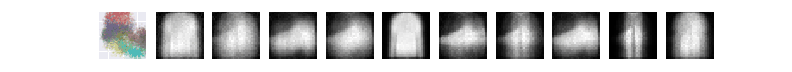

In [14]:
display.Image(filename="cvae.gif.png")

In [0]:
# from google.colab import files
# files.download('cvae.gif')

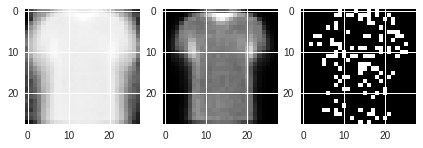

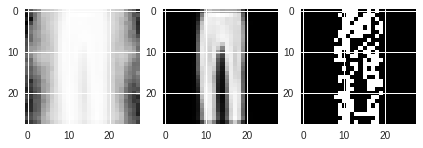

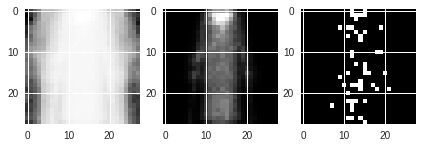

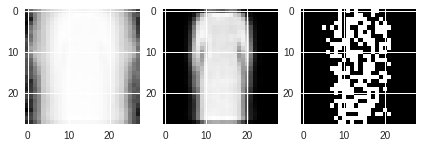

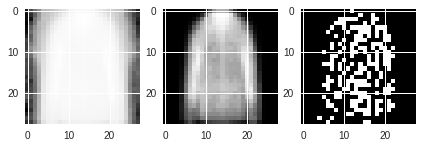

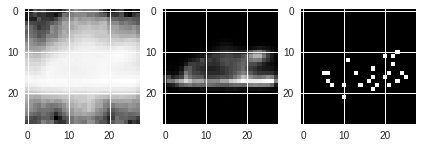

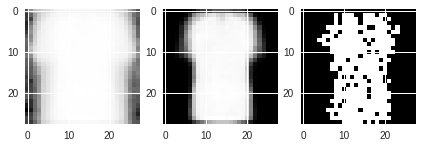

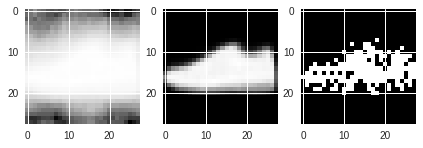

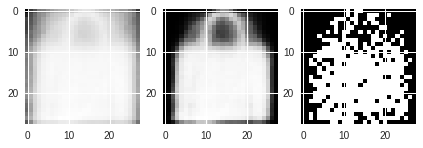

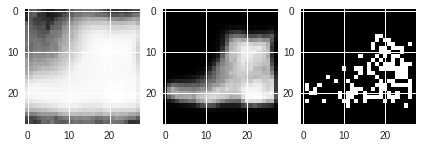

In [16]:
sample_size = 10
random_vector_for_generation = tf.random_normal(shape=[sample_size, 2])
logits = model.decode(random_vector_for_generation, to_categorical(range(10)))
p_x_given_z = tfd.Bernoulli(logits=logits)
p_x_given_z_mean = tfd.Independent(p_x_given_z).mean()
p_x_given_z_sample = p_x_given_z.sample()

for i in range(sample_size):
    x_logit = np.reshape(logits[i], (28,28))
    x_mean = np.reshape(p_x_given_z_mean[i], (28,28))
    x_sample = np.reshape(p_x_given_z_sample[i], (28,28))
    fig_tmp = plt.figure(figsize=(7,4))
    ax_tmp = fig_tmp.add_subplot(131)
    plt.imshow(x_logit, cmap='Greys_r')
    ax_tmp = fig_tmp.add_subplot(132)
    plt.imshow(x_mean, cmap='Greys_r')
    ax_tmp = fig_tmp.add_subplot(133)
    plt.imshow(x_sample, cmap='Greys_r')

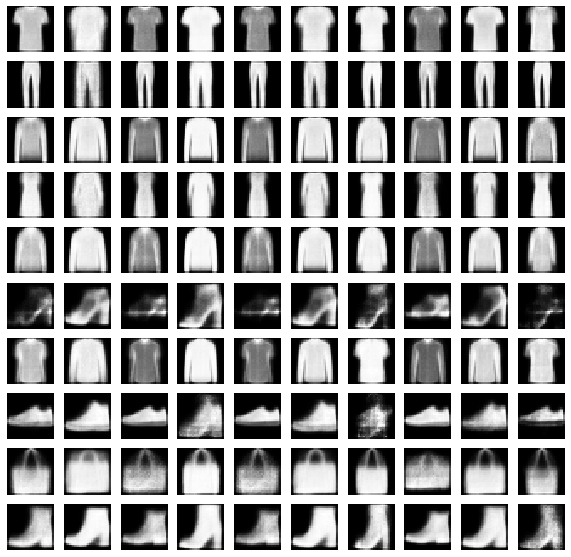

In [17]:
sample_size = 10
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(10,10), 
                         nrows=rows, ncols=cols, 
                         sharex=True, sharey=True)

random_samples = tf.random_normal(shape=[sample_size, 2])
for i, ax_row in enumerate(axes):
  logits = model.decode(random_samples, to_categorical([i]*sample_size, 10))
  p_x_given_z = tfd.Bernoulli(logits=logits)
  p_x_given_z_mean = tfd.Independent(p_x_given_z).mean()
  p_x_given_z_sample = p_x_given_z.sample()
  
  for j, ax in enumerate(ax_row):
    _ = ax.imshow(np.reshape(p_x_given_z_mean[j], (28,28)), cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)